# Medical Chatbot with NLTK

A chatbot is smart code that is capable of communicating similar to a human.

Chatbots are used a lot in customer interaction, marketing on social network sites and instantly messaging the client.

There are two basic types of chatbot models based on how they are built:
- **Retrieval based**.
A retrieval-based chatbot uses predefined input patterns and responses. It then uses some type of heuristic approach to select the appropriate response. It is widely used in the industry to make goal-oriented chatbots where we can customize the tone and flow of the chatbot to drive our customers with the best experience.

- **Generative based models** are not based on some predefined responses.
They are based on *seq 2 seq* neural networks. It is the same idea as machine translation. In machine translation, we translate the source code from one language to another language but here, we are going to transform input into an output. It needs a large amount of data and it is based on Deep Neural Networks (DNN).

## Scope of this chatbot

Build a chatbot using deep learning techniques following the retrieval-based concept. The chatbot will be trained on the dataset which contains conversation categories (intents), patterns, and responses. The model uses a Deep Neural Network with a single hidden layer to classify which category the input message belongs to and then the chatbot will select a random response from the list of responses, which have similar meaning.

Topics the chatbot will be helpful with is helping doctors/patients finding **(1) Adverse drug reaction**, **(2) Blood pressure**, **(3) Hospitals** and **(4)Pharmacies**. It may be used on websites pertaining to hospital, pharmaceutical online stores etc. or modified to fit completely different purposes. Furthermore, this is just a prototype whose functionality can be greatly expanded in topics it can reply to, depth of conversation, answer variert and so on.


## Preparation
The training set and DNN for inference for the chatbot was created in a **<a href="https://github.com/ChristianHallerX/DataScienceProjects/blob/master/Data/chatbot_data/Medical_Chatbot_with_NLTK_Train.ipynb" target="_blank">separate notebook</a>**. The model was trained from the **intents.json** file, which contains:
- "tag", a shorthand for the topic of the conversation,
- "patterns", the user input, multiple alternatives possible for this topic,
- "responses", the chatbot replies,
- "context", a field that correlates an entry with the tag field of another entry, for multiple interactions with user

Files generated in that notebook are:
- **intents.json**, the original file containing the tags, sentences trained on, and selection of replies
- **words.pkl**, a pickle file of the user input words vocacabulary (lemmatized)
- **classes.pkl**, a pickle file containing the unique tags/topics of intents
- **chatbot_model.h5**, a file containing the weights of the trained DNN for prediction

Download the necessary files from **<a href="https://github.com/ChristianHallerX/DataScienceProjects/tree/master/Data/chatbot_data" target="_blank">this repository</a>** to get started.

## Step 1: Imports

In [1]:
import nltk
from nltk.stem import WordNetLemmatizer
import pickle
import numpy as np
from keras.models import load_model
import json
import random
import os

lemmatizer = WordNetLemmatizer()

Using TensorFlow backend.


## Step 2: Load Files

Loading words, model, and replies into objects.

In [2]:
intents = json.loads(open(f'{os.getcwd()}\\Data\\chatbot_data\\intents.json').read())
words = pickle.load(open(f'{os.getcwd()}\\Data\\chatbot_data\\words.pkl','rb'))
classes = pickle.load(open(f'{os.getcwd()}\\Data\\chatbot_data\\classes.pkl','rb'))
model = load_model(f'{os.getcwd()}\\Data\\chatbot_data\\chatbot_model.h5')

## Step 3: Preprocessing the input - Some helper functions

For class prediction, we need to provide input in the same way as we did for training. These helper functions perform text preprocessing when the user clicked "Send" and then predict the class.

In [3]:
def clean_up_sentence(sentence):
    
    # tokenize input pattern - split words into array
    sentence_words = nltk.word_tokenize(sentence)
    
    # stem each word - create short form for word
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    
    return sentence_words
    

# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence
def bow(sentence, words, show_details=True):
    
    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)
    
    # bag of words - matrix of N words, vocabulary matrix
    bag = [0]*len(words)
    
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s: 
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)
                    
    return(np.array(bag))


def predict_class(sentence, model):
    
    # filter out predictions below a threshold
    p = bow(sentence, words,show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]
    
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    
    return return_list

## Step 4: Selecting a response

After predicting the class (tag) of the user input, these functions select a random response from the list of intent (i.e. from intents.json file).

In [4]:
def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
    return result

def chatbot_response(text):
    ints = predict_class(text, model)
    res = getResponse(ints, intents)
    return res

## Step 5: GUI

Code for the Graphical User Interface.

The GUI uses the *tkinter* library, which is an Python interface to the Tk GUI toolkit. Tkinter is Python's de-facto standard GUI.

Taksks of the GUI are: (1) Accept the input message from the user and then (2) use the helper functions to get the response from the bot and then (3) display everything in a window.

In [5]:
import tkinter
from tkinter import *

# send function: add entry to chat window and get chatbot response
def send():
    # get written message and save to variable
    msg = EntryBox.get("1.0",'end-1c').strip()
    # remove message from entry box
    EntryBox.delete("0.0",END)
    
    if msg == "Message":
        # if the user clicks send before entering their own message, "Message" gets inserted again
        # no prediction/response
        EntryBox.insert(END, "Message")
        pass
        # if user clicks send and proper entry
    elif msg != '':
        # activate chat window and insert message
        ChatLog.config(state=NORMAL)
        ChatLog.insert(END, "You: " + msg + '\n\n')
        ChatLog.config(foreground="black", font=("Verdana", 12 ))
        
        # insert bot response to chat window
        res = chatbot_response(msg)
        ChatLog.insert(END, "MedInfo: " + res + '\n\n')
        
        # make window read-only again
        ChatLog.config(state=DISABLED)
        ChatLog.yview(END)

def clear_search(event):
    EntryBox.delete("0.0",END)
    EntryBox.config(foreground="black", font=("Verdana", 12))

### Execute this Cell to start the chatbot GUI

Here, everything comes together. The different objects on the screen are defined and what functions are executed when they are interacted with. The ChatLog text field's state is always set to "Normal" for text inserting and afterwards set to "Disabled" so the user cannot interact with it.

In [6]:
base = Tk()
base.title("MedInfo")
base.geometry("400x500")
base.resizable(width=FALSE, height=FALSE)

# create chat window
ChatLog = Text(base, bd=0, bg="white", height="8", width="50", font="Arial",)

# initial greeting in chat window
ChatLog.config(foreground="black", font=("Verdana", 12 ))
ChatLog.insert(END, "MedInfo: Hello, I can help with... \n\t- Adverse Drug Reaction \n\t- Blood Pressure \n\t- Pharmacy Search \n\t- Hospital Search\n\n")

# disable window = read-only
ChatLog.config(state=DISABLED)

# bind scrollbar to ChatLog window
scrollbar = Scrollbar(base, command=ChatLog.yview, cursor="double_arrow")
ChatLog['yscrollcommand'] = scrollbar.set

# create Button to send message
SendButton = Button(base, font=("Verdana",12,'bold'), text="Send", width="9", height=5,
                    bd=0, bg="blue", activebackground="gold",fg='#ffffff',
                    command= send )

# create the box to enter message
EntryBox = Text(base, bd=0, bg="white",width="29", height="5", font="Arial")

# display a grey text in EntryBox that's removed upon clicking or tab focus
EntryBox.insert(END, "Message")
EntryBox.config(foreground="grey", font=("Verdana", 12))
EntryBox.bind("<Button-1>", clear_search)
EntryBox.bind("<FocusIn>", clear_search) 

# place components at given coordinates in window (x=0 y=0 top left corner)
scrollbar.place(x=376,y=6, height=386)
ChatLog.place(x=6,y=6, height=386, width=370)
EntryBox.place(x=6, y=401, height=90, width=265)
SendButton.place(x=282, y=401, height=90)

base.mainloop()

## Screenshot of GUI
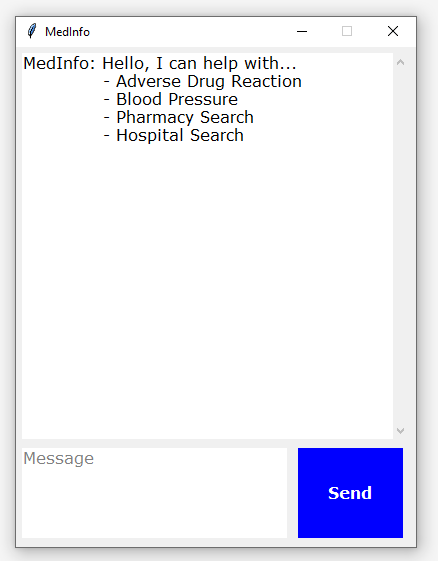